Estimating dynamic specification...


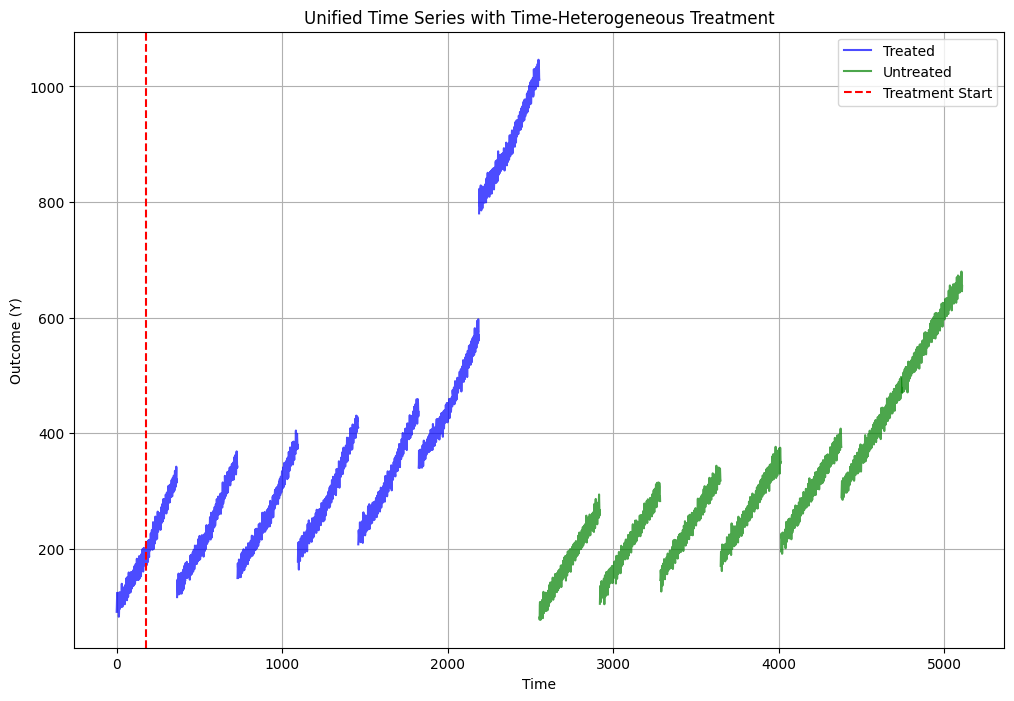

In [2]:
import pandas as pd
import pyfixest as pf
from pyfixest.report.utils import rename_event_study_coefs
import matplotlib.pyplot as plt
import numpy as np

# Generate data with time heterogeneity in treatment effect
np.random.seed(42)
days = 365
trend = 0.5
weekly_seasonality_amplitude = 15
noise_std = 5
advertisement_effect = 50
effect_ramp_days = 200
dates = pd.date_range(start="2023-01-01", periods=days)
weekly_pattern = (weekly_seasonality_amplitude *
                  np.sin(2 * np.pi * (dates.dayofweek / 7.0)))

treated_bases = [100, 130, 160, 190, 220, 350, 800]
untreated_bases = [90, 120, 150, 180, 210, 300, 484]
treatment_date = pd.Timestamp("2023-07-01")

treated_series = []
for base in treated_bases:
    trend_values = np.arange(base, base + trend * days, trend)
    app_installs = trend_values + weekly_pattern + np.random.normal(0, noise_std, size=days)
    app_installs = np.maximum(0, app_installs)
    app_installs = np.array(app_installs)

    for t, date in enumerate(dates):
        if date >= treatment_date:
            days_since_treatment = (date - treatment_date).days
            ramp_effect = min(advertisement_effect * (days_since_treatment / effect_ramp_days), advertisement_effect)
            app_installs[t] += ramp_effect

    treated_series.append(app_installs)

untreated_series = []
for base in untreated_bases:
    trend_values = np.arange(base, base + trend * days, trend)
    app_installs = trend_values + weekly_pattern + np.random.normal(0, noise_std, size=days)
    app_installs = np.maximum(0, app_installs)
    untreated_series.append(app_installs)

reshaped_data = []
unit_index = 1

for treated, series_group in [(1, treated_series), (0, untreated_series)]:
    for series in series_group:
        for t, (date, y_it) in enumerate(zip(dates, series)):
            post_t = 1 if date >= treatment_date else 0
            d_it = post_t * treated
            reshaped_data.append({
                "unit": unit_index,
                "year_numeric": t,  # Numeric representation of the year
                "Y": y_it,
                "post_t": post_t,
                "ever_treated": treated,
                "D_it": d_it
            })
        unit_index += 1

reshaped_df = pd.DataFrame(reshaped_data)

# Dynamic specification for event study
print("Estimating dynamic specification...")
fit_dynamic_twfe = pf.feols(
    "Y ~ i(year_numeric, ever_treated, ref=180) | unit + year_numeric",  # Use numeric reference
    reshaped_df,
    vcov={"CRV1": "unit"},
)

# Plot event study results
fit_dynamic_twfe.iplot(
    coord_flip=False,
    title="Dynamic Event Study for Time-Heterogeneous Treatment",
    figsize=[10, 10],
    yintercept=0,
    xintercept=180,  # Reference period
    labels=rename_event_study_coefs(fit_dynamic_twfe._coefnames),
    plot_backend="matplotlib",
)

# Optional: Plot unified time series
def plot_unified_time_series(data, treatment_date, title="Unified Time Series Plot"):
    plt.figure(figsize=(12, 8))
    for treated, color, label in [(1, "blue", "Treated"), (0, "green", "Untreated")]:
        subset = data[data["ever_treated"] == treated]
        for unit in subset["unit"].unique():
            unit_data = subset[subset["unit"] == unit]
            plt.plot(unit_data.index, unit_data["Y"], color=color, alpha=0.7, label=label if unit == subset["unit"].min() else "")
    plt.axvline(x=data[data['year_numeric'] == 180]['year_numeric'].iloc[0], color="red", linestyle="--", label="Treatment Start")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Outcome (Y)")
    plt.legend()
    plt.grid()
    plt.show()

plot_unified_time_series(reshaped_df, treatment_date, title="Unified Time Series with Time-Heterogeneous Treatment")
